In [1]:
!pip install pyLDAvis -qq
!pip install -qq -U gensim
!pip install spacy -qq
!pip install matplotlib -qq
!pip install seaborn -qq
!python -m spacy download en_core_web_md -qq

2023-07-18 16:36:05.814000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 16:36:07.583728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
reports = pd.read_csv('LDA_Jin_dataset.csv')
reports.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sub-id,group,gender,age,race,employment,income,car,fashion,tech,...,talk_inperson,sns,talk_app,talk_sam,talk_other,text_app,text_sam,text_app.1,comment,purpose
0,sub-01,Samsung,Female,27,White,Employed for wages,"$25,000-$49,999","toyota, subaru","LEVI, CARHART","SAMSUNG, NINTENDO, SONY",...,1,2,0,12,0,0,12,0,IT WAS OK,I'M NOT SURE
1,sub-02,Apple,Male,29,White,Employed for wages,"$100,000-$149,999","BMW, Audi, Porsche, Mercedes, Ferrari Lamborhg...","gucci, guess, LV, H&M, abercrombie and fitch","apple, samsung, lg, motorola, ge",...,5,na,150,100,0,9,1,0,It was fine,Not sure
2,sub-03,Apple,Male,38,White,Employed for wages,"$50,000-$74,999","Lotus, Alfa Romeo, Lancia, Jaguar, Aston Martin",Ray Ban,"AMD, Lenovo, Asus, Nvidia",...,2,NaN,2,3,5,2,3,5,It went fine,no idea
3,sub-04,Samsung,Male,35,White,In between jobs,"$25,000-$49,999","Ford Mustang, Dodge Viper, Chevy Camaro, Mitts...","Under Amour, Coach, Champion, No Fear, Ecko","Samsung, Sony, LG, HP",...,0,70,4,5,1,4,4,2,Was alright.,Iphone vs. Samsung
4,sub-05,Samsung,Male,40,White,Employed for wages,"$25,000-$49,999",dodge,gucci,ibm,...,0,150,0,3,0,0,3,0,seems pretty interesting for the most part,smartphones


In [7]:
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sub-id         479 non-null    object 
 1   group          479 non-null    object 
 2   gender         479 non-null    object 
 3   age            479 non-null    int64  
 4   race           479 non-null    object 
 5   employment     479 non-null    object 
 6   income         479 non-null    object 
 7   car            479 non-null    object 
 8   fashion        476 non-null    object 
 9   tech           478 non-null    object 
 10  purchase       479 non-null    object 
 11  history        479 non-null    float64
 12  products       479 non-null    object 
 13  homo_sam       479 non-null    int64  
 14  homo_app       479 non-null    int64  
 15  share_app      479 non-null    int64  
 16  share_sam      479 non-null    int64  
 17  share_other    479 non-null    int64  
 18  network_ap

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Our spaCy model:
nlp = en_core_web_md.load()
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(reports['purchase']):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
reports['tokens'] = tokens
reports['tokens']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      [samsung, basically, phone, brand, like, apple...
1      [buy, brand, apple, computer, use, work, find,...
2      [look, pre, own, phone, try, update, model, go...
3      [good, possible, design, functionality, price,...
4      [cheap, need, storage, space, camera, quality,...
                             ...                        
474    [buy, current, phone, brand, samsung, phone, y...
475    [choose, positive, experience, android, servic...
476    [purchase, app, want, run, decent, time, good,...
477    [big, fan, apple, viable, choice, android, rec...
478    [buy, current, smartphone, brand, want, good, ...
Name: tokens, Length: 479, dtype: object

In [11]:
#Apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(reports['tokens'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
print(dictionary.token2id)

{'apple': 0, 'basically': 1, 'brand': 2, 'crash': 3, 'like': 4, 'lot': 5, 'phone': 6, 'phones': 7, 'run': 8, 'samsung': 9, 'slow': 10, 'able': 11, 'buy': 12, 'computer': 13, 'easy': 14, 'find': 15, 'laptop': 16, 'use': 17, 'work': 18, 'compromise': 19, 'good': 20, 'look': 21, 'model': 22, 'own': 23, 'pre': 24, 'price': 25, 'quality': 26, 'try': 27, 'update': 28, 'deal': 29, 'design': 30, 'functionality': 31, 'functioning': 32, 'perform': 33, 'possible': 34, 'solid': 35, 'sure': 36, 'camera': 37, 'cheap': 38, 'need': 39, 'rate': 40, 'space': 41, 'storage': 42, 'best': 43, 'feature': 44, 'get': 45, 'local': 46, 'research': 47, 'review': 48, 'see': 49, 'start': 50, 'stock': 51, 'transfer': 52, 'unlock': 53, 'card': 54, 'dependable': 55, 'fair': 56, 'luck': 57, 'memory': 58, 'product': 59, 'television': 60, 'battery': 61, 'day': 62, 'display': 63, 'large': 64, 'lean': 65, 'performance': 66, 'read': 67, 'recharge': 68, 'sharp': 69, 'time': 70, 'well': 71, 'alrig': 72, 'alright': 73, 'att': 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
corpus = [dictionary.doc2bow(doc) for doc in reports['tokens']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


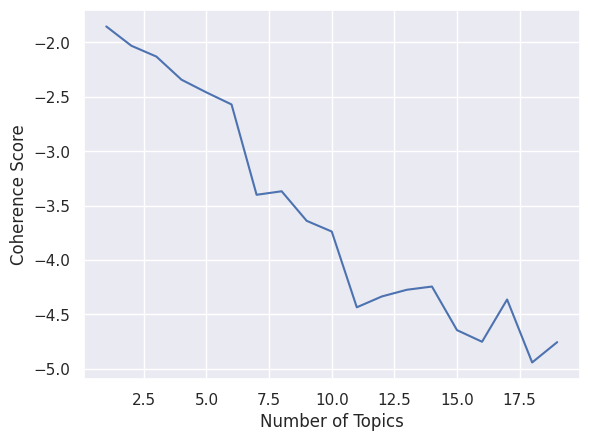

In [16]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


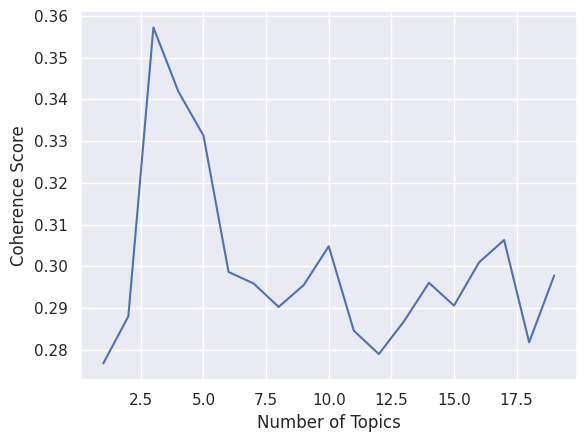

In [17]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = reports['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [18]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = 4, passes=100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
lda_model.print_topics(-1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.046*"samsung" + 0.038*"new" + 0.038*"old" + 0.037*"brand" + 0.036*"iphone" + 0.033*"apple" + 0.033*"need" + 0.031*"year" + 0.031*"buy" + 0.026*"good"'),
 (1,
  '0.084*"samsung" + 0.066*"like" + 0.035*"want" + 0.034*"brand" + 0.029*"smartphone" + 0.026*"buy" + 0.023*"iphone" + 0.021*"feel" + 0.020*"apple" + 0.018*"galaxy"'),
 (2,
  '0.123*"apple" + 0.053*"use" + 0.047*"product" + 0.039*"easy" + 0.033*"user" + 0.028*"like" + 0.027*"brand" + 0.023*"device" + 0.019*"friendly" + 0.017*"iphone"'),
 (3,
  '0.073*"iphone" + 0.046*"love" + 0.044*"use" + 0.043*"buy" + 0.041*"like" + 0.032*"thing" + 0.030*"easy" + 0.028*"come" + 0.026*"apple" + 0.026*"try"'),
 (4,
  '0.088*"brand" + 0.054*"buy" + 0.051*"good" + 0.041*"samsung" + 0.037*"price" + 0.036*"smartphone" + 0.036*"current" + 0.034*"feature" + 0.033*"quality" + 0.030*"camera"')]

In [23]:
# Where does a text belong to
lda_model[corpus][0]
reports['purchase'][0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'SAMSUNG IS BASICALLY THE ONLY PHONE BRAND I LIKE. I HATE APPLE PHONES AND ALL OF THE OTHER PHONE BRANDS RUN REALLY SLOW AND CRASH A LOT.'

In [24]:
# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# Save the report
pyLDAvis.save_html(lda_display, 'index.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
